# Model Demo
This notebook serves to give a simple demo of the `PoseEstimator` and how pretrained weights can be used with it to simply use a pretrained model.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

We create an instance of the pose estimator. Next we load the pretrained weights for this model.

In [4]:
from openpose_cycling.model import PoseEstimator

pose_estimator = PoseEstimator()

pretrained_weights = './model.h5'
pose_estimator.model.load_weights(pretrained_weights, by_name=True)

As a demo we use an image of Chritopher Froome during the Giro d'Italia in 2018. We load this using `OpenCV`. Some care needs to be taken since by default `OpenCV` loads images in BGR format.

In [57]:
import os
import cv2

data_dir = '../data'
image_name = 'sample_image.jpg'

demo_img_path = os.path.join(data_dir, image_name)

image = cv2.imread(demo_img_path)

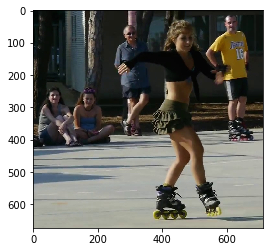

In [58]:
import matplotlib.pyplot as plt
plt.imshow(image[..., [2, 1, 0]])

Next, we plot the heatmap as outputted by the model per joint. This heatmap indicates regions of interest where joints are located.

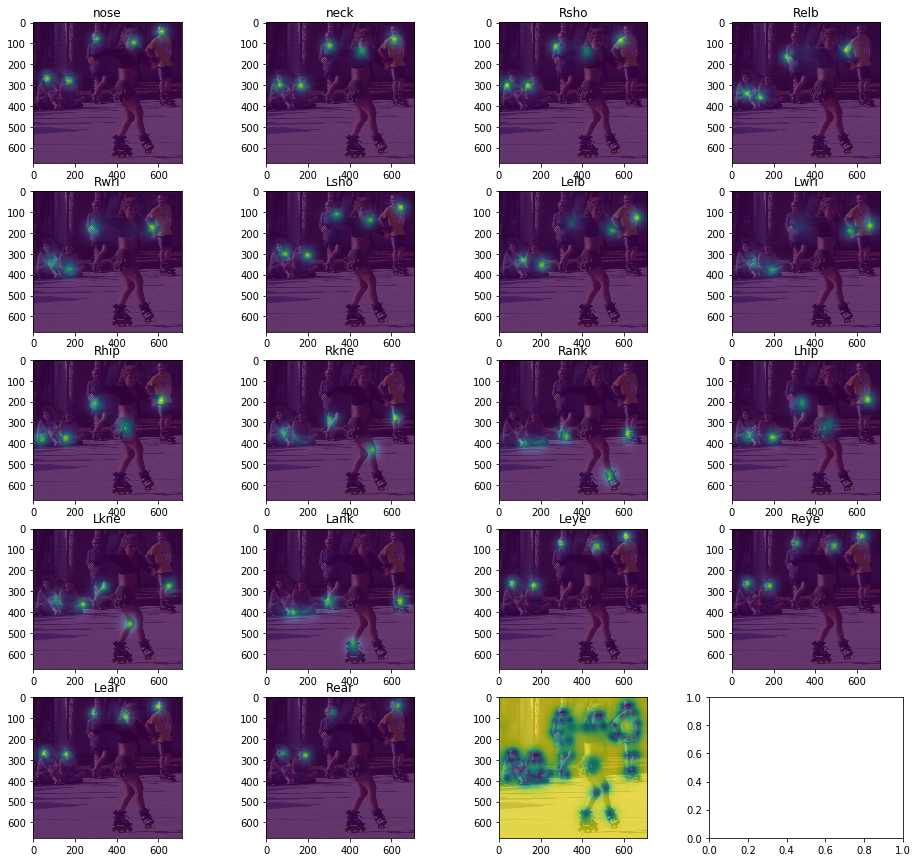

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from openpose_cycling import config as c
import math

N_COLS = 4
N_ROWS = math.ceil(len(c.ELEMENTS_MAP) / 4)

paf, heatmap = pose_estimator.predict_paf_and_heatmap(image[None,...,])
paf = paf[0]
heatmap = heatmap[0]
heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

fig, axs = plt.subplots(ncols=N_COLS, nrows=N_ROWS, figsize=(N_COLS*4, N_ROWS*3))

for (el_id, name), ax in zip(c.ELEMENTS_MAP.items(), np.reshape(axs, (-1,))):
    ax.imshow(image[..., [2, 1, 0]])
    ax.imshow(heatmap_resized[..., el_id], alpha=0.7)
    
    ax.set_title(name)

The following plots show how the heatmaps are transformed into point estimates for all the joints.

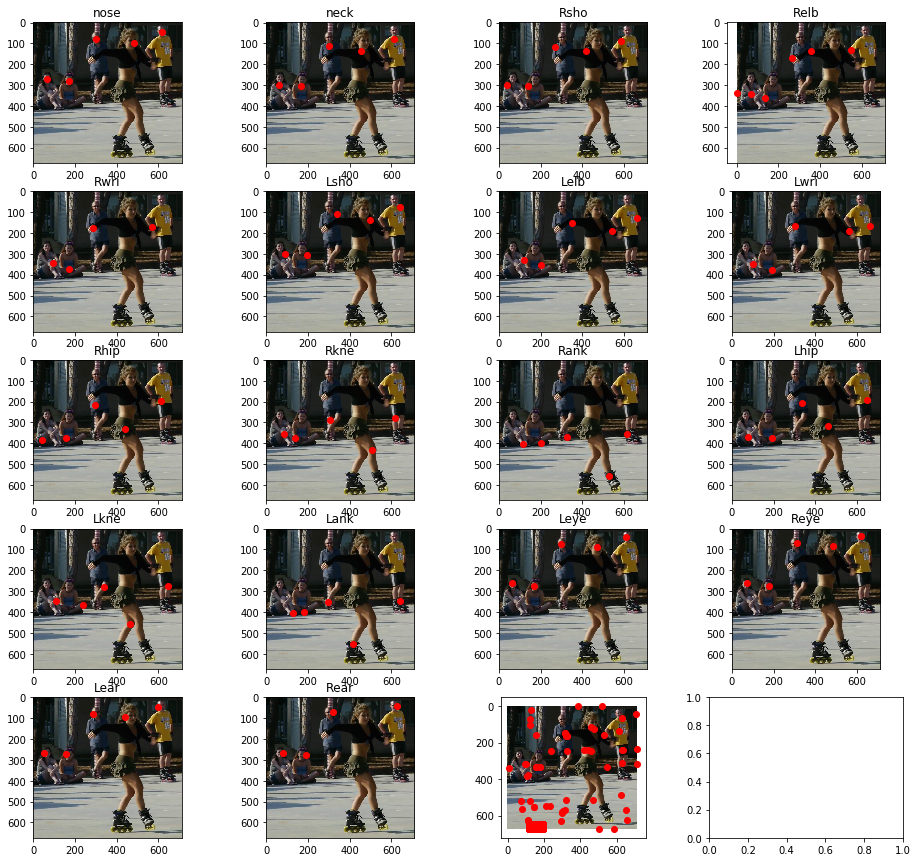

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from openpose_cycling import config as c
import math

N_COLS = 4
N_ROWS = math.ceil(len(c.ELEMENTS_MAP) / 4)


joints = pose_estimator.predict_from_image(image[None,...])[0]
fig, axs = plt.subplots(ncols=N_COLS, nrows=N_ROWS, figsize=(N_COLS*4, N_ROWS*3))

for (el_id, name), ax in zip(c.ELEMENTS_MAP.items(), np.reshape(axs, (-1,))):
    ax.imshow(image[..., [2, 1, 0]])
    ax.scatter(joints[el_id][0], joints[el_id][1], c='r')
    
    ax.set_title(name)

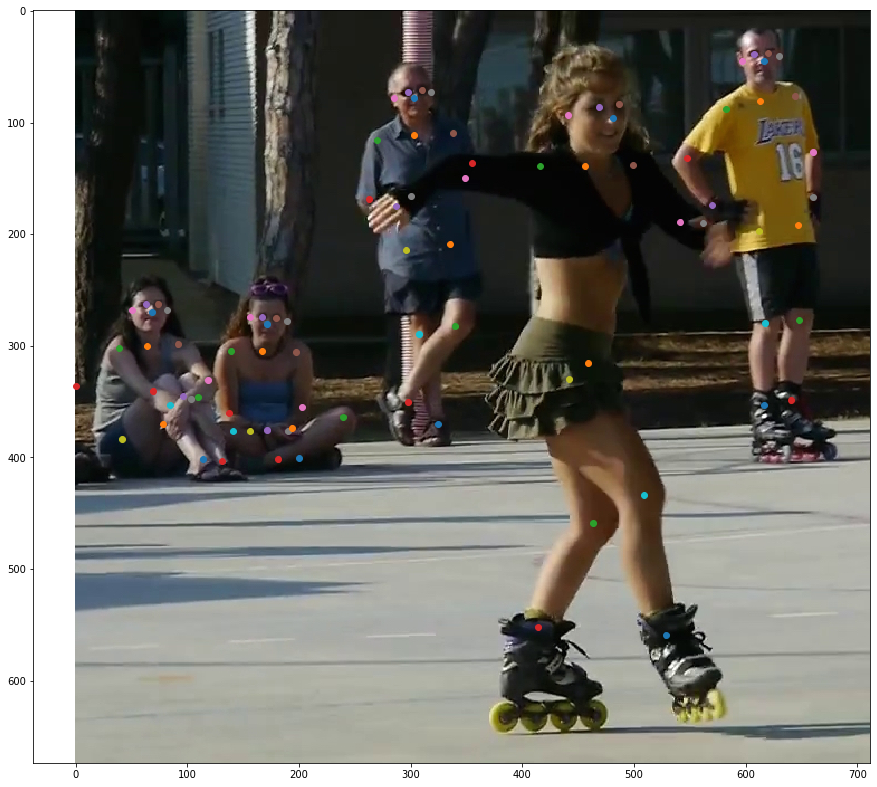

In [68]:
plt.figure(figsize=(15,15))

plt.imshow(image[..., [2, 1, 0]])
for joint_coords in joints[:-1]:
    plt.scatter(joint_coords[0], joint_coords[1])

# PAF linking

In [70]:
np.array([[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]) -1 

array([[ 1,  2],
       [ 1,  5],
       [ 2,  3],
       [ 3,  4],
       [ 5,  6],
       [ 6,  7],
       [ 1,  8],
       [ 8,  9],
       [ 9, 10],
       [ 1, 11],
       [11, 12],
       [12, 13],
       [ 1,  0],
       [ 0, 14],
       [14, 16],
       [ 0, 15],
       [15, 17],
       [ 2, 16],
       [ 5, 17]])

In [61]:
import matplotlib

In [62]:
import numpy.ma as ma

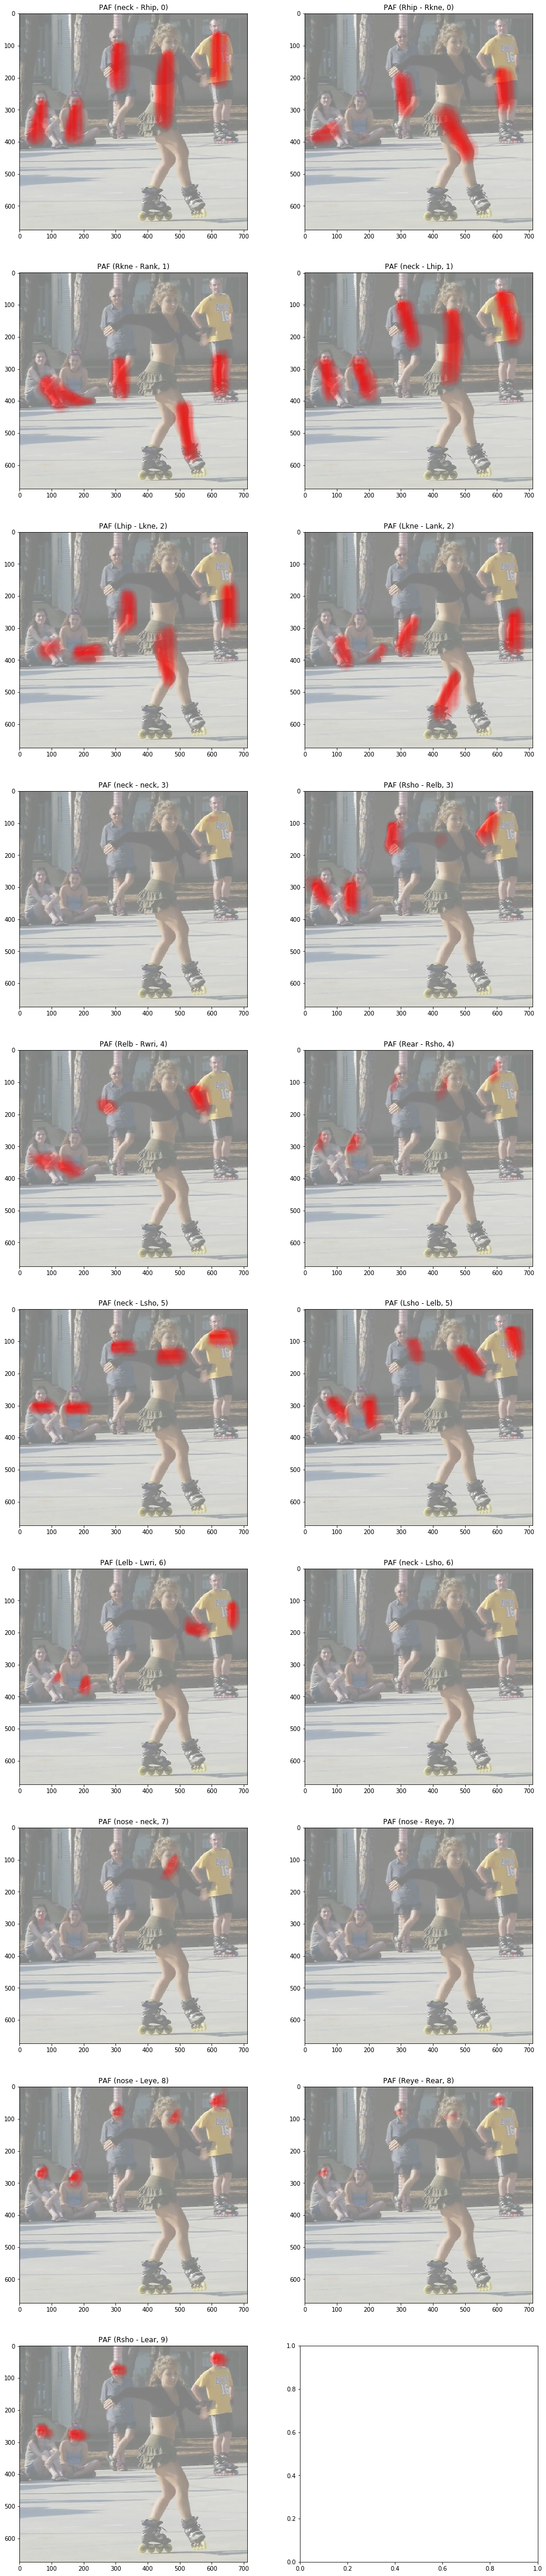

In [73]:
N_COLS = 2
N_ROWS = math.ceil(len(c.ELEMENTS_MAP) / N_COLS)
s = 2

fig, axs = plt.subplots(ncols=N_COLS, nrows=N_ROWS, figsize=(N_COLS*8, N_ROWS*8))
axs = axs.reshape(-1)



for i, paf_orig_shape in enumerate(np.rollaxis(paf, axis=-2)):
    joint_1_id, joint_2_id = c.LINKS[i]
    joint_1_name, joint_2_name = c.ELEMENTS[joint_1_id], c.ELEMENTS[joint_2_id]
    ax = axs[i]
    
    paf_rezied = cv2.resize(paf_orig_shape, (image.shape[1], image.shape[0]))
    U = paf_rezied[:,:,0] * -1
    V = paf_rezied[:,:,1]
    X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
    M = np.zeros(U.shape, dtype='bool')
    M[U**2 + V**2 < 0.1 * 0.1] = True
    U = ma.masked_array(U, mask=M)
    V = ma.masked_array(V, mask=M)
    
    ax.set_title('PAF (%s - %s, %d)' % ((joint_1_name, joint_2_name, i // 2)))
    ax.imshow(image[:,:,[2,1,0]], alpha = .5)
    Q = ax.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
                  scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

In [136]:
start = joints[0].T.astype('int')
stop = joints[8].T.astype('int')

In [310]:
def lines_between(start_coords, stop_coords, n_steps=100):
    x_grad = (start[None, :, 0] - stop[None, :, 0].T)
    y_grad = (start[None, :, 1] - stop[None, :, 1].T)
    grads = np.concatenate([x_grad[..., None], y_grad[..., None]], axis=-1)
    
    alpha = np.linspace(0, 1, num=n_steps)
    
    # Create the line segments and transpose such that the first index matches the index
    # in the start array and the last index matches that in the end array. This should be
    # more intuitive.
    x_lines = (start[:, 0] - alpha[:, None, None] * x_grad[None, ...]).transpose([0, 2, 1])
    y_lines = (start[:, 1] - alpha[:, None, None] * y_grad[None, ...]).transpose([0, 2, 1])
    
    lines = np.concatenate([x_lines[..., None], y_lines[..., None]], axis=-1)
    return lines, grads
    

In [326]:
lines, grads = lines_between(start, stop, n_steps=100)
normed_grads = grads / np.linalg.norm(grads, axis=-1)[..., None]

In [352]:
x_ind = lines[..., 0].astype('int')
y_ind = lines[..., 1].astype('int')

In [372]:
paf_along_line.shape

(100, 5, 5, 2)

In [376]:
normed_paf_along_line.shape

(100, 5, 5, 1)

In [458]:
paf_along_line = (paf_rezied * [-1, 1])[y_ind, x_ind]
normed_paf_along_line = paf_along_line / np.linalg.norm(paf_along_line, axis=-1)[..., None]

cosine_similarity = (normed_paf_along_line * -1 * normed_grads).sum(axis=-1)

In [459]:
from scipy.optimize import linear_sum_assignment

In [460]:
integrated_similarity = cosine_similarity.mean(axis=0)

In [461]:
first_point, second_point = linear_sum_assignment(-1 * integrated_similarity)

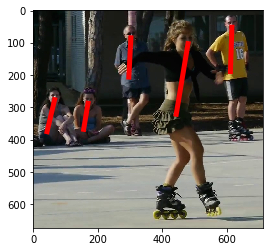

In [462]:
fig, ax = plt.subplots()

ax.imshow(image[..., [2, 1, 0]])

segments = [(start[id_1], stop[id_2])for id_1, id_2 in zip(first_point, second_point)]
ax.add_collection(mc.LineCollection(segments, colors='r', linewidths=5))

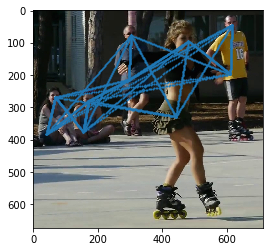

In [463]:
lines_2d = lines.reshape((-1, 2))
plt.imshow(image[..., [2, 1, 0]])
plt.scatter(lines_2d[:, 0], lines_2d[:, 1], s=1)

In [294]:
paf_rezied[x_ind, y_ind]

array([[[[8.90979281e-05, 7.06767896e-05],
         [8.90979281e-05, 7.06767896e-05],
         [8.90979281e-05, 7.06767896e-05],
         [8.90979281e-05, 7.06767896e-05],
         [8.90979281e-05, 7.06767896e-05]],

        [[1.01747738e-04, 6.03164625e-05],
         [1.01747738e-04, 6.03164625e-05],
         [1.01747738e-04, 6.03164625e-05],
         [1.01747738e-04, 6.03164625e-05],
         [1.01747738e-04, 6.03164625e-05]],

        [[7.28170898e-05, 6.08594802e-05],
         [7.28170898e-05, 6.08594802e-05],
         [7.28170898e-05, 6.08594802e-05],
         [7.28170898e-05, 6.08594802e-05],
         [7.28170898e-05, 6.08594802e-05]],

        [[1.01088721e-04, 7.16832524e-05],
         [1.01088721e-04, 7.16832524e-05],
         [1.01088721e-04, 7.16832524e-05],
         [1.01088721e-04, 7.16832524e-05],
         [1.01088721e-04, 7.16832524e-05]],

        [[1.17658682e-04, 7.30740748e-05],
         [1.17658682e-04, 7.30740748e-05],
         [1.17658682e-04, 7.30740748e-05],
   

In [287]:
lines.shape

(3, 5, 5, 2)

In [285]:
paf_rezied[lines.reshape((-1, 2))]

(75, 2, 712, 2)

In [271]:
image.shape

(674, 712, 3)

In [280]:
paf_rezied[lines, :].shape

(3, 5, 5, 2, 712, 2)

In [282]:
paf_rezied.shape

(674, 712, 2)

In [279]:
paf

array([[[[8.17035208e-04, 2.29933602e-03],
         [1.12636189e-05, 0.00000000e+00],
         [1.65338972e-04, 1.84631902e-04],
         ...,
         [9.54366308e-05, 0.00000000e+00],
         [0.00000000e+00, 9.07576105e-05],
         [1.47299196e-04, 7.55619913e-05]],

        [[8.17035208e-04, 2.29933602e-03],
         [1.12636189e-05, 0.00000000e+00],
         [1.65338972e-04, 1.84631902e-04],
         ...,
         [9.54366308e-05, 0.00000000e+00],
         [0.00000000e+00, 9.07576105e-05],
         [1.47299196e-04, 7.55619913e-05]],

        [[8.17035208e-04, 2.29933602e-03],
         [1.12636189e-05, 0.00000000e+00],
         [1.65338972e-04, 1.84631902e-04],
         ...,
         [9.54366308e-05, 0.00000000e+00],
         [0.00000000e+00, 9.07576105e-05],
         [1.47299196e-04, 7.55619913e-05]],

        ...,

        [[1.00136548e-03, 3.05283023e-03],
         [3.51255391e-05, 2.54683788e-05],
         [1.79195781e-04, 1.98563280e-04],
         ...,
         [1.02605605e

In [274]:
lines

array([[[[616,  44],
         [616,  44],
         [616,  44],
         [616,  44],
         [616,  44]],

        [[303,  77],
         [303,  77],
         [303,  77],
         [303,  77],
         [303,  77]],

        [[481,  95],
         [481,  95],
         [481,  95],
         [481,  95],
         [481,  95]],

        [[ 68, 269],
         [ 68, 269],
         [ 68, 269],
         [ 68, 269],
         [ 68, 269]],

        [[171, 280],
         [171, 280],
         [171, 280],
         [171, 280],
         [171, 280]]],


       [[[613, 120],
         [456, 129],
         [529, 186],
         [385, 210],
         [328, 213]],

        [[457, 137],
         [299, 145],
         [372, 203],
         [229, 226],
         [172, 230]],

        [[546, 146],
         [388, 154],
         [461, 212],
         [318, 235],
         [261, 239]],

        [[339, 233],
         [182, 241],
         [255, 299],
         [111, 322],
         [ 54, 326]],

        [[391, 238],
         [233,

In [263]:
start[0]

array([616,  44])

In [266]:
stop[1]

array([296, 214])

In [182]:
stop[None, :, 0].T

array([[611],
       [296],
       [442],
       [155],
       [ 41]])

In [168]:
start[None, :, 0]

array([[616, 303, 481,  68, 171]])

In [174]:
np.arange(1, 6)[None, :][None, :].T

array([[[1]],

       [[2]],

       [[3]],

       [[4]],

       [[5]]])

In [171]:
np.arange(1, 6)

array([1, 2, 3, 4, 5])

In [167]:
start

array([[616,  44],
       [303,  77],
       [481,  95],
       [ 68, 269],
       [171, 280]])

In [164]:
start[:, 0]

array([616, 303, 481,  68, 171])

In [163]:
stop[:, 0].T

array([611, 296, 442, 155,  41])

In [158]:
start[None, ...] - stop.T[None, ...]

ValueError: operands could not be broadcast together with shapes (1,5,2) (1,2,5) 

In [150]:
stop.T

array([[611, 296, 442, 155,  41],
       [197, 214, 329, 376, 383]])

In [143]:
line_coords = lines_between(start, stop).astype('int')

In [145]:
line_coords

(100, 5, 2)

In [138]:
start

array([[616,  44],
       [303,  77],
       [481,  95],
       [ 68, 269],
       [171, 280]])

In [139]:
stop

array([[611, 197],
       [296, 214],
       [442, 329],
       [155, 376],
       [ 41, 383]])

In [132]:
lines_between(start, stop, 4).astype('int')

array([[[616,  44],
        [303,  77],
        [481,  95],
        [ 68, 269],
        [171, 280]],

       [[615,  56],
        [303,  88],
        [472, 109],
        [ 66, 279],
        [169, 288]],

       [[614,  68],
        [303,  99],
        [464, 123],
        [ 64, 289],
        [167, 296]],

       [[613,  80],
        [303, 111],
        [456, 138],
        [ 63, 300],
        [166, 304]]])

In [99]:
steps = get_diagonals(start, stop)

In [123]:
n_steps = 100


In [124]:
steps

array([[  3, -36],
       [  0, -34],
       [ 25, -43],
       [  5, -31],
       [  5, -24]])

In [125]:
steps

array([[  3, -36],
       [  0, -34],
       [ 25, -43],
       [  5, -31],
       [  5, -24]])

In [126]:
alpha[:, None, None] * steps

array([[[  0. ,  -0. ],
        [  0. ,  -0. ],
        [  0. ,  -0. ],
        [  0. ,  -0. ],
        [  0. ,  -0. ]],

       [[  1.5, -18. ],
        [  0. , -17. ],
        [ 12.5, -21.5],
        [  2.5, -15.5],
        [  2.5, -12. ]],

       [[  3. , -36. ],
        [  0. , -34. ],
        [ 25. , -43. ],
        [  5. , -31. ],
        [  5. , -24. ]]])

In [91]:
start

array([[616,  44],
       [303,  77],
       [481,  95],
       [ 68, 269],
       [171, 280]])

In [92]:
stop

array([[613,  80],
       [303, 111],
       [456, 138],
       [ 63, 300],
       [166, 304]])